# 推荐系统之Node2vec
主要思想：在DeepWalk的基础上更近一步，通过调整随机游走的权重的方法使Graph Embedding的结果更倾向于体现网络的同质性或结构性。  
同质性：指距离相近节点的Embedding应尽量近似；  
结构性：指的是结构上相似的节点Embedding应该尽量相似。
## 随机游走
说明：依照指定概率随机游走，需要对游走节点进行判别：  
（１）当为起始节点时，需要在无前驱节点t的情况下，随机选择跳转节点；  
（２）当存在起始节点，即存在(t, v)时，对下一步的随机节点的选取按照跳转概率进行选取。

In [1]:
def node2vec_walk(self, walk_length, start_node):

    G = self.G
    alias_nodes = self.alias_nodes  # 节点采样
    alias_edges = self.alias_edges  # 边采样

    walk = [start_node]

    while len(walk) < walk_length:
        cur = walk[-1]
        cur_nbrs = list(G.neighbors(cur))
        
        if len(cur_nbrs) > 0:
            if len(walk) == 1:  # 随机游走的起始节点,只有节点v
                walk.append(
                    # accept, alias
                    # alias_nodes = {cur:[[list(accept), liast(alias)]]}
                    # '1397': ([1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0])
                    cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
            else:  # 随机游走存在(t, v)
                prev = walk[-2]
                edge = (prev, cur)
                # alias_edges = {edge:[[list(accept), liast(alias)]]}
                # ('1397', '1470'): ([1, 0.9032258064516129, 0.22580645161290322
                # , 0.9032258064516129, 0.9032258064516129, 0.22580645161290322, 0.22580645161290322]
                # , [0, 0, 0, 0, 0, 0, 0])
                next_node = cur_nbrs[alias_sample(alias_edges[edge][0],
                                                  alias_edges[edge][1])]
                walk.append(next_node)
        else:
            break

    return walk

## 跳转概率
### 跳转概率可能性
说明：在跳转概率的转换中，$d_{tx}$指节点t到节点x的距离，参数p和q共同控制这随机游走的可能性。参数p被称为返回参数（return parameter），p越小，随机游走回节点t的可能性越大，Node2Vec就更注重表达网络的结构性。参数q被称为进出参数(in-out parameter)，q越小，随机游走到远方节点的可能性越大，Node2Vex更注重表达网络的同质性;反之，当前节点更可能在附近节点游走。   
1. 跳转概率转移图  
![](./imgs/跳转概率.svg)  
2. 具体参数说明：

x1 为结点 v 和结点 t 的共同邻居，设置边 v->x1 的权重为 1；  
t 为前序结点，设置边 v-> t 的权重为返回参数 p：  
- p > 1 则下一步倾向于访问共同邻居；  
- p < 1 则下一步倾向于回到前序结点。 

x2 和 x3 是结点 v 的其他一阶邻居结点，设置边的权重为进出参数 q：  
- q > 1 则下一步倾向于访问共同邻居；  
- q < 1 则下一步倾向于访问其他一阶邻居结点。

### 同质性和结构性


- 同质性(DFS)  
![](./imgs/q.svg)
- 结构性(BFS)  
![](./imgs/p.svg)

### 代码解析

In [2]:
def get_alias_edge(self, t, v):
    """
    compute unnormalized transition probability between nodes v and its neighbors give the previous visited node t.
    :param t:
    :param v:
    :return:
    """
    G = self.G
    p = self.p
    q = self.q

    unnormalized_probs = []
    # 寻找x的邻接顶点
    for x in G.neighbors(v):
        weight = G[v][x].get('weight', 1.0)  # w_vx
        if x == t:  # d_tx == 0
            unnormalized_probs.append(weight/p)
        elif G.has_edge(x, t):  # d_tx == 1
            unnormalized_probs.append(weight)
        else:  # d_tx > 1
            unnormalized_probs.append(weight/q)
    
    # 不同跳转节点概率的归一化操作       
    norm_const = sum(unnormalized_probs)
    normalized_probs = [
        float(u_prob)/norm_const for u_prob in unnormalized_probs]

    return create_alias_table(normalized_probs)  # 放回(t, v)前驱下的alias采样计算accept, alias

## alias sample(别名采样法)
**alias和accept数组维护**：维护两个数组$accept$和$alias$，$accept$数组中的$accept[i]$表示事件i占第i列矩形的面积的比例。 $alias[i]$表示第i列中不是事件i的另一个事件的编号。

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 源码

In [4]:
def gen_prob_dist(N):
    
    p = np.random.randint(0,100,N)
    
    return p/np.sum(p)

def create_alias_table(area_ratio):

    l = len(area_ratio)
    accept, alias = [0] * l, [0] * l
    small, large = [], []
    
    # 与面积的均值比较    
    # 面积值小于1的index-->small
    # 面积值大于１的index-->large
    for i, prob in enumerate(area_ratio):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        # 搜索长短
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio[small_idx]
        alias[small_idx] = large_idx
        # 取长补短
        area_ratio[large_idx] = area_ratio[large_idx] - (1 - area_ratio[small_idx])
        # 重新更新判别
        if area_ratio[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)
            
    # 事件发生的概率为1
    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1

    return accept, alias

def alias_sample(accept, alias):
    
    N = len(accept)
    i = int(np.random.random()*N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

def simulate(N=4, k=10000):


#     truth = gen_prob_dist(N)
    truth = np.array([0.3, 0.1, 0.1, 0.5])
    area_ratio = truth*N
    accept,alias = create_alias_table(area_ratio)
    print("accept: ", accept, "\nalias: ", alias)
    ans = np.zeros(N)
    # 模拟k次抽取结果的取值
    for _ in range(k):
        i = alias_sample(accept,alias)
        ans[i] += 1
        
    return ans/np.sum(ans),truth

if __name__ == "__main__":
    
    alias_result,truth = simulate()

accept:  [1, 0.4, 0.4, 0.7999999999999999] 
alias:  [0, 3, 3, 0]


### 演算模拟（[视频讲解](https://www.bilibili.com/video/BV13y4y117KB?p=2&spm_id_from=pageDriver)）
- 原始时间概率
![](./imgs/alias-1.png)
- 相乘N，获得均值
![](./imgs/alias-2.png)
- 取长补短，事件不超过二
![](./imgs/alias-3.png)

### 采样事件概率和真实事件概率分布情况

<Figure size 864x576 with 0 Axes>

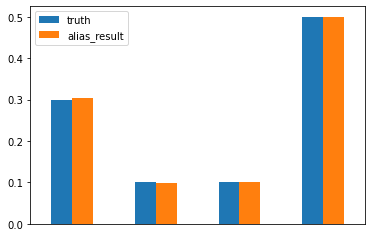

In [5]:
df = pd.DataFrame({"truth": truth, "alias_result":alias_result})
plt.figure(figsize=(12, 8))
df.plot.bar()
plt.xticks([])
plt.show()

## 实战

In [6]:
import numpy as np
from ge.classify import read_node_label, Classifier
from ge import Node2Vec
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
import warnings


warnings.filterwarnings("ignore")

In [27]:
def evaluate_embeddings(embeddings):
    X, Y = read_node_label('./data/wiki/wiki_labels.txt')
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)


def plot_embeddings(embeddings, ):
    X, Y = read_node_label('./data/wiki/wiki_labels.txt')
    plt.figure(figsize = (12, 8))
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.savefig("./imgs/q.png")
    plt.show()

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'micro': 0.6756756756756757, 'macro': 0.5863946078772986, 'samples': 0.6756756756756757, 'weighted': 0.6696464790209589, 'acc': 0.6756756756756757}


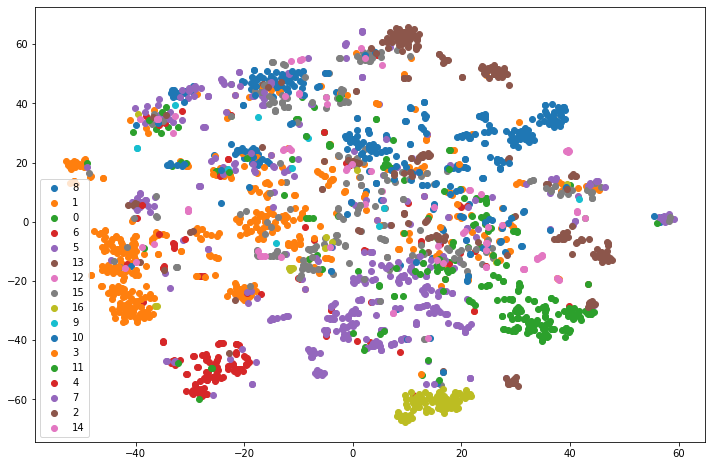

In [28]:
G = nx.read_edgelist('./data/wiki/Wiki_edgelist.txt',
                     create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])
model = Node2Vec(G, walk_length=10, num_walks=80,
                 p=100, q=0.25, workers=1, use_rejection_sampling=0)
model.train(window_size=5, iter=3)
embeddings = model.get_embeddings()

evaluate_embeddings(embeddings)
plot_embeddings(embeddings)

# 参考
[时间复杂度为O(1)的抽样算法——别名采样（alias sample method）](https://www.pianshen.com/article/56641016608/)  
[Alias Method:时间复杂度O(1)的离散采样方法](https://zhuanlan.zhihu.com/p/54867139)  
[【数学】时间复杂度O(1)的离散采样算法—— Alias method/别名采样方法](https://blog.csdn.net/haolexiao/article/details/65157026)  
[别名采样 alias sampling 视频讲解和代码都有](https://www.bilibili.com/video/BV13y4y117KB?p=2&spm_id_from=pageDriver)  
[详解图表示学习经典算法 node2vec](https://www.6aiq.com/article/1588470435933)